# 🧩 Análisis de redes con Python
**Workshop 4**

### *Creado por: Megan García Antivar* 🌱

En matemáticas y en ciencias de la computación, la teoría de grafos o análisis de redes estudia las propiedades de los grafos
(también llamadas gráficas). Un grafo es un conjunto, no vacío, de objetos llamados **vértices** (o nodos) y una selección de pares de vértices,
llamados aristas (edges en inglés) que pueden ser orientados o no. Típicamente, un grafo se representa mediante una serie de puntos (los vértices)
conectados por **líneas** (las aristas).

Tanto los nodos como las aristas pueden contener metadatos en forma de pares clave-valor. Por ejemplo, en una red social los nodos «Hugo» y “Eric” pueden tener cada uno un atributo {"edad 25 }, mientras que la arista entre ellos podría almacenar `{ «first_met»: «2016-05-21» }`.

**¿Por qué modelar los datos como un gráfo?** 🥸

Representar los datos como un grafo permite abordar cuestiones que son difíciles de responder con tablas convencionales, como:

- ¿Quiénes son las personas influyentes clave dentro de una comunidad en línea?
- ¿Cuál es la ruta óptima entre dos ciudades en una red de transporte?
- ¿Existen clusters o comunidades densamente conectadas en la red?
- Encontrar el camino más corto utilizando una red de calles específica es un problema SIG común que tiene muchas aplicaciones prácticas. Por ejemplo, la navegación, una de esas aplicaciones para las que se utilizan algoritmos de encaminamiento para encontrar la ruta óptima entre dos o más puntos.

Examinando la estructura de un grafo podemos calcular métricas a nivel de nodo (por ejemplo, la centralidad), identificar puentes críticos o detectar agrupaciones naturales de comunidades.

## 1. Obtener una red ruteable

El paquete NetworkX ofrece varias herramientas para analizar redes e implementa distintos algoritmos de encaminamiento, como el de Dijkstra o el A*. Ambos se utilizan habitualmente para encontrar los caminos más cortos a lo largo de las redes de transporte.

Para poder realizar análisis de redes es necesario, por supuesto, disponer de una red que se utilice para los análisis. El paquete OSMnx nos permite recuperar redes ruteables de OpenStreetMap para varios modos de transporte (a pie, en bicicleta y en coche). OSMnx también envuelve algunas de las funcionalidades de NetworkX de una manera conveniente para su uso en los datos de OpenStreetMap.

En la siguiente sección, usaremos OSMnx para encontrar el camino más corto entre dos puntos basado en caminos ciclables. Con sólo pequeñas modificaciones, podemos repetir el análisis para la red de calles peatonales.

In [103]:
# Descargar librería para trabajar OpenStreetMap

!pip install osmnx

### 📦 ¿Qué es `osmnx`?

`osmnx` es una biblioteca de Python muy potente que permite trabajar con datos geoespaciales y de redes urbanas usando OpenStreetMap. A continuación se resumen sus principales funcionalidades:

| Funcionalidad | Descripción |
|---------------|-------------|
| Descargar datos | Permite obtener redes de calles, caminos y otros elementos desde OpenStreetMap. |
| Convertir en grafos | Convierte los datos en grafos de `networkx` o en `GeoDataFrames` para análisis geoespacial. |
| Análisis de redes | Calcula rutas más cortas, medidas de centralidad, accesibilidad, conectividad, etc. |
| Visualización | Genera mapas y gráficos de la red, rutas, puntos de interés, etc. |
| Trabajar con lugares reales | Permite usar nombres de lugares (ej. "Bogotá", "Madrid") o polígonos personalizados como entrada. |

### A. Importar librerías 📚

In [137]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from shapely.geometry import Polygon, MultiPolygon
import networkx as nx

### 1.1. Análisis de redes en Teusaquillo

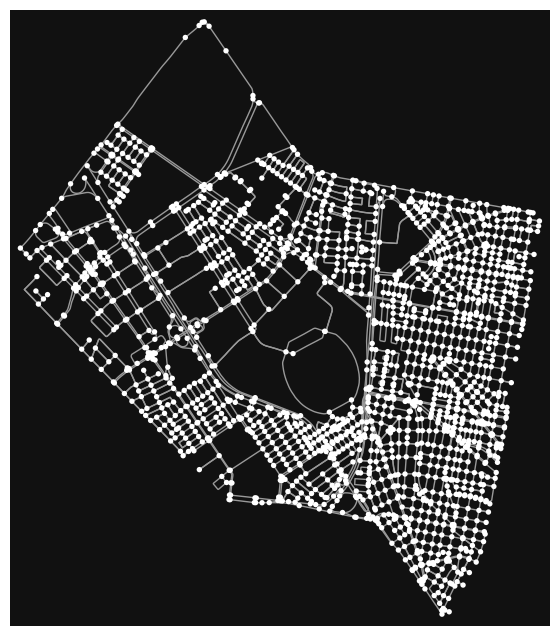

In [105]:
PLACE_NAME = "Teusaquillo, Bogotá, Colombia"
graph = ox.graph_from_place(
    PLACE_NAME,
    network_type="drive"
)
figure, ax = ox.plot_graph(graph)

### 📍 Expandir el área de análisis

A veces, las rutas más cortas pueden extenderse levemente más allá de los límites administrativos de un barrio. Para evitar rutas truncadas o sin conexión en los bordes de la red, es útil cargar un área más grande a partir de un punto central o un buffer sobre el límite administrativo de interés, para este caso, se aplicó un buffer de un kilómetros.

<Axes: >

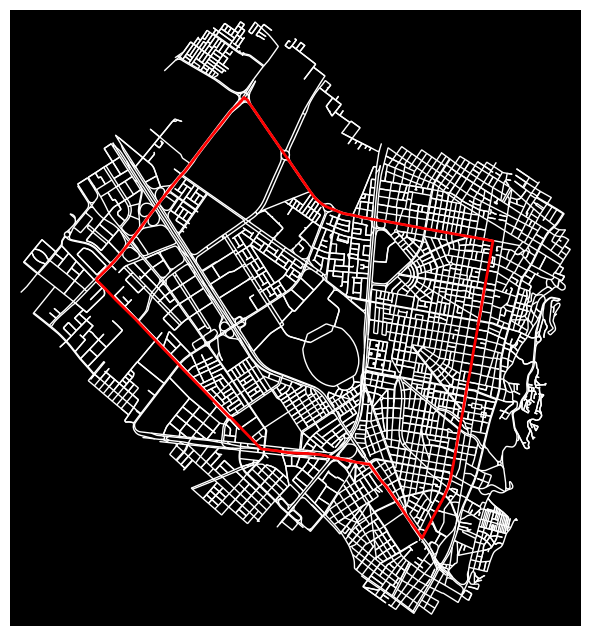

In [106]:
# Obtener el polígono de Teusaquillo
gdf = ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia")

# Proyectar para poder usar metros
gdf = gdf.to_crs(epsg=3857)

# Aplicar buffer (ej. 1000 metros)
gdf["geometry"] = gdf.buffer(1000)

# Volver a coordenadas geográficas
gdf = gdf.to_crs(epsg=4326)

# Descargar la red expandida con forma de la localidad + buffer
graph = ox.graph_from_polygon(gdf.geometry[0], network_type="drive")

# Visualizar
fig, ax = ox.plot_graph(graph, show=False, close=False, node_size=0.5, edge_color="white", bgcolor="black")
ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia").plot(ax=ax, facecolor="none", edgecolor="red", linewidth=2)

### 1.2. ⏱️ Incorporación de velocidades estimadas y tiempos de viaje

El análisis de redes viales en entornos urbanos no solo depende de la distancia física entre dos puntos, sino también del tiempo que toma recorrer dichas distancias. En este sentido, el uso del parámetro por defecto `weight="length"` en algoritmos como Dijkstra o A* solo refleja la ruta más corta en metros, pero no necesariamente la más rápida.

Para aproximar de forma más realista el comportamiento de la movilidad en Teusaquillo, se incorporan dos mejoras al grafo vial:

- **Velocidad estimada por tipo de vía:** mediante la función `ox.add_edge_speeds()`, se asignan velocidades promedio basadas en el tipo de calle (e.g., residencial, primaria, terciaria), utilizando heurísticas provenientes de OpenStreetMap.
  
- **Tiempo estimado de viaje:** con `ox.add_edge_travel_times()`, se calcula un nuevo atributo `travel_time` en cada arista (tramo), estimando el tiempo en segundos según su longitud y velocidad.

Estas transformaciones permiten evaluar rutas no solo en términos de su longitud, sino también en función del tiempo que tomaría recorrerlas, habilitando análisis comparativos más cercanos a condiciones reales de tránsito urbano.

> **Nota:** *Este enfoque no contempla condiciones dinámicas como semáforos, congestión horaria o incidentes, pero constituye un primer paso hacia la modelación temporal en análisis de accesibilidad y movilidad urbana.*

In [107]:
# Añadir velocidades estimadas por tipo de vía (km/h)
graph = ox.add_edge_speeds(graph)

# Calcular el tiempo estimado de viaje en segundos
graph = ox.add_edge_travel_times(graph)

# Convertir el grafo a GeoDataFrame (aristas), incluyendo u y v como columnas
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()

# Seleccionar y renombrar columnas para visualización detallada
cols = ["u", "v", "name", "highway", "oneway", "length", "speed_kph", "travel_time", "geometry", "maxspeed"]
df_tramos = edges[cols].copy()

df_tramos.rename(columns={
    "u": "nodo_origen",
    "v": "nodo_destino",
    "name": "nombre_via",
    "highway": "tipo_via",
    "oneway": "una_via",
    "length": "longitud_m",
    "speed_kph": "velocidad_kph",
    "travel_time": "tiempo_seg",
    "geometry": "geometria",
    "maxspeed": "velocidad_max_legal"
}, inplace=True)

# Visualizar los primeros tramos
df_tramos.head()

,nodo_origen,nodo_destino,nombre_via,tipo_via,una_via,longitud_m,velocidad_kph,tiempo_seg,geometria,velocidad_max_legal
0,253761985,6327920589,Calle 33,residential,True,82.303149,30.000000,9.876378,"LINESTRING (-74.06771 4.62007, -74.06779 4.620...",30
1,253761985,12431107060,Avenida Carrera 7,primary,True,293.919728,30.000000,35.270367,"LINESTRING (-74.06771 4.62007, -74.06785 4.619...",30
2,253761988,5891814904,Avenida Eldorado,primary,True,111.851731,38.540541,10.447862,"LINESTRING (-74.07138 4.61329, -74.07181 4.6142)",NaN
3,253762003,500959293,Carrera 24,residential,True,54.439641,29.818469,6.572528,"LINESTRING (-74.07673 4.62248, -74.07632 4.62275)",NaN
4,253762003,264153961,Calle 27,residential,True,91.009857,30.000000,10.921183,"LINESTRING (-74.07673 4.62248, -74.07633 4.62176)",30


### 📑 Descripción de columnas del grafo vial

Al convertir el grafo de red en un `GeoDataFrame` mediante `osmnx.graph_to_gdfs()`, se obtiene una tabla descriptiva en atributos por cada tramo de vía. A continuación se describen las principales columnas disponibles para el análisis:

| Columna              | Descripción                                                | Tipo de dato         |
|----------------------|------------------------------------------------------------|-----------------------|
| `nodo_origen (u)`    | ID del nodo inicial del tramo                              | Entero (`int`)        |
| `nodo_destino (v)`   | ID del nodo final del tramo                                | Entero (`int`)        |
| `nombre_via`         | Nombre de la vía (cuando está disponible)                  | Cadena (`str`)        |
| `tipo_via`           | Clasificación según OpenStreetMap (`residential`, `primary`, etc.) | Cadena (`str`) |
| `una_via`            | Indica si el tramo es unidireccional (`True` o `False`)    | Booleano (`bool`)     |
| `longitud_m`         | Longitud del tramo en metros                               | Flotante (`float`)    |
| `velocidad_kph`      | Velocidad estimada por tipo de vía (asignada por `osmnx`)  | Flotante (`float`)    |
| `tiempo_seg`         | Tiempo estimado de viaje (segundos)                        | Flotante (`float`)    |
| `velocidad_max_legal`| Límite de velocidad legal según OpenStreetMap (si existe)  | Entero o lista (`int` o `list`) |
| `geometria`          | Geometría de la línea del tramo                            | `shapely.geometry`    |

Esta tabla permite caracterizar cada segmento de la red y usar atributos como el tipo de vía, longitud o tiempo estimado para algoritmos de ruteo y análisis espacial.


### 1.3. Distribución de calles según tipo de vía (OpenStreetMap)

Además de visualizar espacialmente la red vial por tipo de vía, es útil identificar su composición en términos cuantitativos. Para ello, se calcula el número de tramos viales que pertenecen a cada categoría de la etiqueta `highway` provista por OpenStreetMap. Este análisis permite identificar la jerarquía vial predominante en el área de estudio (por ejemplo, si se trata principalmente de calles residenciales, vías primarias o terciarias), lo cual es fundamental para interpretar la estructura urbana y las posibles rutas óptimas según el tipo de viaje o modo de transporte.


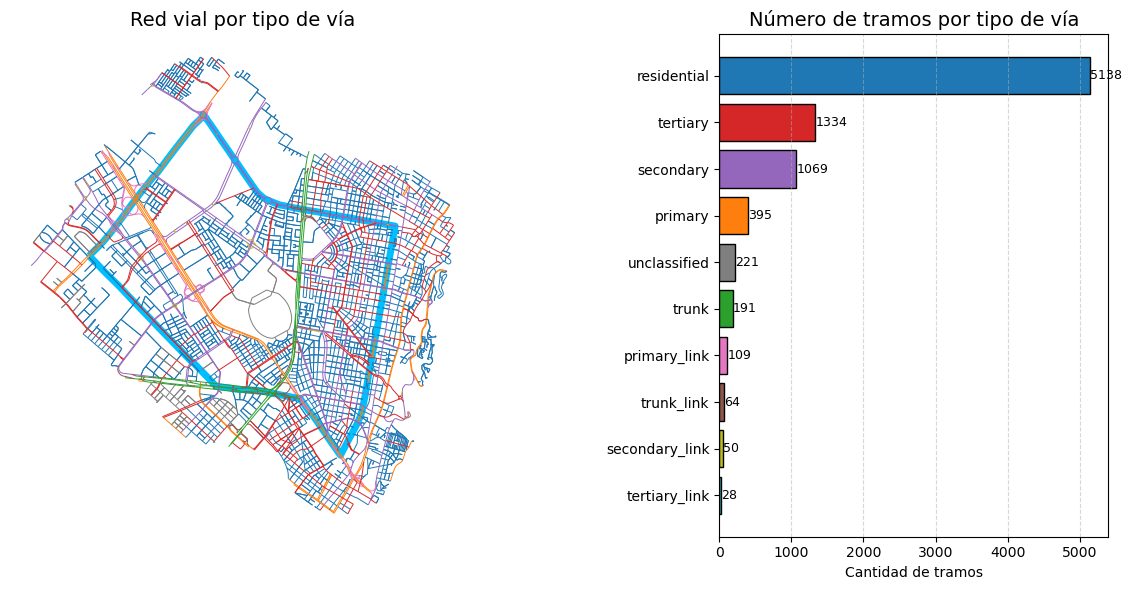

In [110]:
# Asegurar que el campo 'highway' sea una cadena (en caso de listas, toma el primer elemento)
edges["highway"] = edges["highway"].apply(lambda x: x[0] if isinstance(x, list) else x)

# Generar colormap y colores únicos para cada tipo de vía
tipos_via = edges["highway"].unique()
cmap_base = plt.get_cmap("tab20")
colors = {tipo: mcolors.to_hex(cmap_base(i / len(tipos_via))) for i, tipo in enumerate(tipos_via)}

# 2. Preparar conteo de tramos
conteo_vias = edges["highway"].value_counts().sort_values(ascending=True)
colores_barras = [colors.get(tipo, "#999999") for tipo in conteo_vias.index]

# 3. Crear figura con subplots (mapa + gráfico)
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1])

# === Subplot 1: Mapa ===
ax0 = fig.add_subplot(gs[0])
for tipo, group in edges.groupby("highway"):
    group.plot(ax=ax0, linewidth=0.7, edgecolor=colors.get(tipo, "gray"))

# Límite de Teusaquillo en color diferenciado (azul claro)
gdf_localidad = ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia")
gdf_localidad.plot(ax=ax0, facecolor="none", edgecolor="deepskyblue", linewidth=5)

ax0.set_title("Red vial por tipo de vía", fontsize=14)
ax0.axis("off")

# === Subplot 2: Gráfico de barras ===
ax1 = fig.add_subplot(gs[1])
bars = ax1.barh(conteo_vias.index, conteo_vias.values, color=colores_barras, edgecolor="black")

# Añadir valores en las barras
for bar in bars:
    ancho = bar.get_width()
    ax1.text(ancho + 1, bar.get_y() + bar.get_height()/2, str(int(ancho)), va='center', fontsize=9)

ax1.set_title("Número de tramos por tipo de vía", fontsize=14)
ax1.set_xlabel("Cantidad de tramos")
ax1.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### 1.4. Transformación a un sistema de referencia proyectado (EPSG:3116)

Aunque OSMnx puede reproyectar automáticamente a la zona UTM más adecuada, en este caso se optó por transformar explícitamente el grafo al sistema de coordenadas EPSG:3116 (MAGNA-SIRGAS / Colombia Bogotá), ampliamente utilizado en proyectos urbanos en Colombia.

El uso de un sistema de referencia proyectado permite que las distancias se expresen en metros en lugar de grados, lo cual es esencial para análisis como el cálculo de rutas más cortas, tiempos de viaje, buffers de accesibilidad, entre otros.

La transformación se realiza utilizando la función `ox.project_graph()`, especificando el CRS destino con el código EPSG correspondiente.


In [111]:
# Reproyectar el grafo manualmente a EPSG:3116
graph_proj = ox.project_graph(graph, to_crs="EPSG:3116")

# Convertir a GeoDataFrames
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj)

# Verificar sistema de referencia
print("CRS proyectado:", nodes_proj.crs)

CRS proyectado: EPSG:3116


## 2. Análisis estadístico de la red vial

Una vez proyectado el grafo, es posible calcular una serie de estadísticas estructurales sobre la red vial utilizando la función `ox.basic_stats()`, que resume propiedades clave como:

- Número de nodos y aristas
- Longitud total y promedio de calles
- Densidad de intersecciones
- Complejidad estructural de la red (índices como `circuity` o `self_loop_proportion`)

### 2.1. Envolvente convexa

Inicialmente, estos cálculos no incorporan el área física cubierta por la red. Para calcular métricas de **densidad (nodos/km², intersecciones/km², etc.)**, es necesario estimar dicha área. OSMnx no lo hace automáticamente, pero puede resolverse fácilmente calculando la **envolvente convexa** (convex hull) de todos los tramos viales.

Una vez calculada esta geometría, su área se pasa como argumento a `ox.basic_stats(graph, area=...)`, lo que permite obtener métricas más robustas y comparables espacialmente.

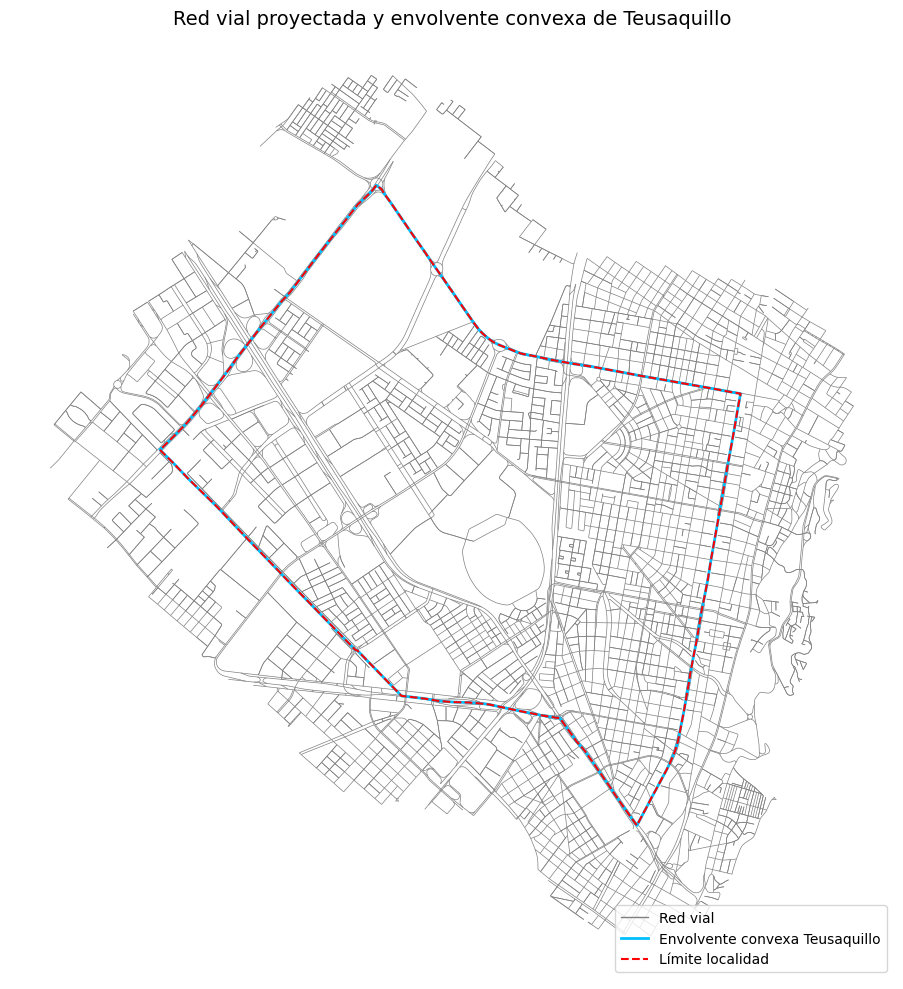

In [112]:
# Obtener geometría proyectada de Teusaquillo
gdf_teusa_proj = ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia").to_crs(edges_proj.crs)

# Calcular envolvente convexa y recortarla al límite real
convex_hull = edges_proj.geometry.union_all().convex_hull
convex_hull_clipped = convex_hull.intersection(gdf_teusa_proj.geometry.iloc[0])

# Crear figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar red vial
edges_proj.plot(ax=ax, linewidth=0.5, edgecolor="gray", zorder=1)

# Dibujar envolvente convexa recortada
if convex_hull_clipped.geom_type == "Polygon":
    ax.plot(*convex_hull_clipped.exterior.xy, color="deepskyblue", linewidth=2, label="Envolvente convexa", zorder=2)
elif convex_hull_clipped.geom_type == "MultiPolygon":
    for poly in convex_hull_clipped:
        ax.plot(*poly.exterior.xy, color="deepskyblue", linewidth=2, zorder=2)

# Dibujar límite de Teusaquillo 
gdf_teusa_proj.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5, linestyle="--", label="Límite localidad", zorder=3)

# Crear leyenda
legend_elements = [
    Line2D([0], [0], color='gray', lw=1, label='Red vial'),
    Line2D([0], [0], color='deepskyblue', lw=2, label='Envolvente convexa Teusaquillo'),
    Line2D([0], [0], color='red', linestyle='--', lw=1.5, label='Límite localidad')
]
ax.legend(handles=legend_elements, loc="lower right")

# Título y visual
ax.set_title("Red vial proyectada y envolvente convexa de Teusaquillo", fontsize=14)
ax.axis("off")
plt.tight_layout()
plt.show()

In [113]:
# Obtener límite real de Teusaquillo
gdf_teusa = ox.geocode_to_gdf("Teusaquillo, Bogotá, Colombia")

# Descargar grafo restringido al polígono oficial
graph = ox.graph_from_polygon(gdf_teusa.geometry.iloc[0], network_type='drive')

# Proyectar a EPSG:3116
graph_proj = ox.project_graph(graph, to_crs="EPSG:3116")

# Reproyectar el polígono también
gdf_teusa_proj = gdf_teusa.to_crs("EPSG:3116")

# Calcular área real del límite
area_teusa = gdf_teusa_proj.geometry.area.iloc[0]
print(f"Área de Teusaquillo (m²): {area_teusa:,.2f}")

# Estadísticas ajustadas al área real de la localidad
stats_area = ox.basic_stats(graph_proj, area=area_teusa)
print("Estadísticas ajustadas por área real de Teusaquillo:")
print(stats_area)

Área de Teusaquillo (m²): 14,213,035.20
Estadísticas ajustadas por área real de Teusaquillo:
{'n': 1932, 'm': 4137, 'k_avg': 4.282608695652174, 'edge_length_total': 352843.55873586494, 'edge_length_avg': 85.28971688079888, 'streets_per_node_avg': 3.244824016563147, 'streets_per_node_counts': {0: 0, 1: 97, 2: 7, 3: 1166, 4: 651, 5: 10, 6: 1}, 'streets_per_node_proportions': {0: 0.0, 1: 0.05020703933747412, 2: 0.0036231884057971015, 3: 0.6035196687370601, 4: 0.33695652173913043, 5: 0.005175983436853002, 6: 0.0005175983436853002}, 'intersection_count': 1835, 'street_length_total': 267322.6265294007, 'street_segment_count': 3100, 'street_length_avg': 86.23310533206474, 'circuity_avg': 1.0333082041863377, 'self_loop_proportion': 0.0, 'node_density_km': np.float64(135.93155671224292), 'intersection_density_km': np.float64(129.10683569718722), 'edge_density_km': np.float64(24825.348972491633), 'street_density_km': np.float64(18808.271619330724)}


> **Observación metodológica**
>
> Para el cálculo de las estadísticas topológicas y métricas de densidad de la red vial, se utilizó el **límite oficial de la localidad de Teusaquillo**, sin aplicar buffers ni envolventes convexas. Esta decisión metodológica responde a la necesidad de garantizar que los resultados representen **exclusivamente la morfología vial interna** de la localidad, evitando la sobreestimación de variables clave como el número de nodos, aristas, longitud total de calles o número de intersecciones.
>
> El uso de buffers o envolventes convexas, si bien puede ser útil en análisis regionales o para asegurar continuidad geométrica, **incluye porciones de red externa** que no pertenecen administrativamente a Teusaquillo. Esto puede distorsionar las métricas de conectividad y densidad urbana, afectando la validez del análisis comparativo entre localidades o unidades espaciales normalizadas.
>
> Por tanto, todas las estadísticas presentadas a continuación están **espacialmente restringidas al área real de Teusaquillo**, según la delimitación oficial del Distrito Capital de Bogotá.

### 2.2 Estadísticas básicas y análisis de densidad vial

Tras recortar la red vial al límite real de Teusaquillo y proyectarla al sistema EPSG:3116, se calcularon las siguientes estadísticas clave con `ox.basic_stats()`:

- **Nodos (`n`)**: 1932  
- **Aristas (`m`)**: 4137  
- **Longitud total de calles**: 267,322.63 m  
- **Longitud promedio por segmento**: 86.23 m  
- **Número de intersecciones**: 1835  
- **Calles por nodo (promedio)**: 3.24  
- **Proporción de auto-bucles**: 0.0  
- **Índice de *circuity* promedio**: 1.03  

Al considerar el área oficial de la localidad de Teusaquillo, equivalente a **14.21 km²**, se obtuvieron los siguientes indicadores de densidad:

| Indicador                       | Valor estimado                  |
|--------------------------------|---------------------------------|
| Densidad de nodos              | 135.93 nodos/km²                |
| Densidad de intersecciones     | 129.13 inters/km²               |
| Densidad de aristas            | 24,825.39 m/km² (≈24.83 km/km²) |
| Densidad de calles reales      | 18,888.27 m/km² (≈18.89 km/km²) |

Estas cifras reflejan un entramado vial **moderadamente denso y bien conectado**, característico de una centralidad urbana establecida. La longitud promedio de los segmentos cercana a 86 metros, y la alta proporción de intersecciones por unidad de superficie refuerzan esta lectura de alta conectividad local.

### 2.3 Composición y jerarquía vial: análisis por tipo de calle

La red vial urbana se compone de diferentes tipos de calles que cumplen funciones específicas dentro del tejido urbano. A partir del atributo `highway` del conjunto de datos de OSM, se calcularon las longitudes totales asociadas a cada clase de vía.

En el caso de Teusaquillo, la mayor proporción de la red corresponde a calles clasificadas como residenciales, lo cual es esperable en un entorno predominantemente urbano consolidado. Las calles primarias y secundarias complementan esta jerarquía, actuando como vías colectoras y estructurantes del flujo vehicular.

> La longitud total de las vías clasificadas como:
>
> - **residential** es de {glue:}`long_res` km  
> - **primary** es de {glue:}`long_prim` km  
> - **secondary** es de {glue:}`long_sec` km

A continuación, se presentan las cinco clases de vía con mayor longitud total en la red:


#### 2.3.1  Calcular la longitud total de calles por tipo (`highway`)

Algunos tramos viales tienen múltiples etiquetas en la columna `highway`, registradas como listas. Para este análisis se toma únicamente la primera etiqueta como representante del tipo de calle. Posteriormente, se agrupan los tramos según esta categoría y se calcula la longitud total por tipo.

In [114]:
# Convertir listas en la columna 'highway' a strings (tomar solo el primer valor)
edges_proj["highway_clean"] = edges_proj["highway"].apply(lambda x: x[0] if isinstance(x, list) else x)

# Agrupar por tipo limpio y sumar longitud
longitudes_por_tipo = edges_proj.groupby("highway_clean")["length"].sum().sort_values(ascending=False)

# Visualizar las 10 clases más comunes
longitudes_por_tipo.head(10)

highway_clean
residential       421592.250365
tertiary          103441.158411
secondary          97505.849203
primary            56828.034322
trunk              25245.887523
unclassified       25173.123001
primary_link       13344.348095
trunk_link          7042.099084
secondary_link      2377.394720
tertiary_link        754.573971
Name: length, dtype: float64

#### 2.3.2 Visualización del top 5 por longitud total

A continuación se muestra un gráfico de barras con las cinco clases de calle que concentran la mayor longitud total en Teusaquillo.

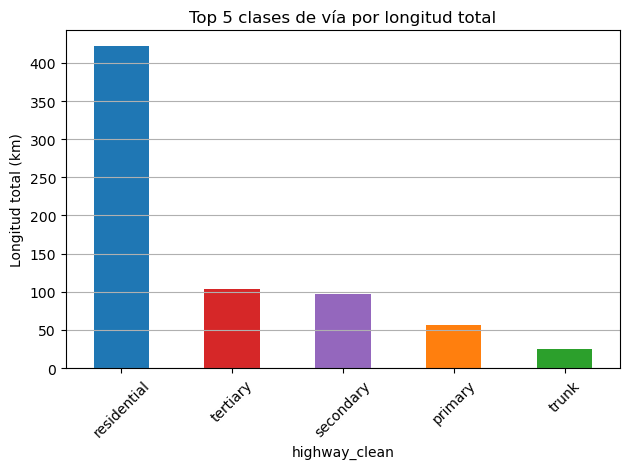

In [115]:
# Colores personalizados por tipo
color_map = {
    "residential": "#1f77b4",
    "primary": "#ff7f0e",
    "secondary": "#9467bd",
    "tertiary": "#d62728",
    "unclassified": "#7f7f7f",
    "trunk": "#2ca02c",
    "living_street": "#800080"
}

# Gráfico
top5.plot(kind="bar", color=top5_colors)
plt.ylabel("Longitud total (km)")
plt.title("Top 5 clases de vía por longitud total")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

#### 2.3.3. Longitud promedio de los segmentos por tipo de calle

Se calcula ahora la longitud promedio de cada tramo de calle, según su clasificación funcional (`highway_clean`). Se resaltan las tres más relevantes.

In [116]:
# Calcular longitud promedio
longitud_media = edges_proj.groupby("highway_clean")["length"].mean().sort_values(ascending=False)

# Ejemplos clave
longitud_media.loc[["residential", "primary", "secondary", "tertiary"]]

highway_clean
residential     82.053766
primary        143.868441
secondary       91.212207
tertiary        77.542098
Name: length, dtype: float64

#### 2.3.4 Generar variables dinámicas para glue

Las siguientes variables insertables permiten incorporar automáticamente los valores numéricos en textos del notebook.

In [117]:
!pip install myst-nb

In [118]:
import myst_nb

# Convertir longitudes de metros a kilómetros y redondear
myst_nb.glue("long_res", round(longitudes_por_tipo["residential"] / 1000, 1))
myst_nb.glue("long_prim", round(longitudes_por_tipo["primary"] / 1000, 1))
myst_nb.glue("long_sec", round(longitudes_por_tipo["secondary"] / 1000, 1))
myst_nb.glue("long_sec", round(longitudes_por_tipo["tertiary"] / 1000, 1))

np.float64(421.6)

np.float64(56.8)

np.float64(97.5)

np.float64(103.4)

#### 2.3.5 Interpretación del patrón vial

> La longitud total de las vías clasificadas como:
>
> - **Recidencial** es de 421.6 km  
> - **Primaria** es de 56.8 km  
> - **Secundaria** es de 97.5 km
> - **Terciaria** es de 103.4 km

Estos resultados evidencian que la red vial de Teusaquillo está fuertemente dominada por calles residenciales, que representan el entramado más fino y extenso de la localidad. Las calles primarias y secundarias, aunque significativamente menos extensas, cumplen una función estructurante en la movilidad interlocal, actuando como ejes de conexión y distribución vehicular de mayor jerarquía.

## 4. Análisis del camino más corto y más rápido

Para este análisis dentro de la localidad de Teusaquillo en Bogotá, seleccionamos dos puntos significativos ubicados en extremos opuestos de la localidad. Ambos se encuentran dentro del límite administrativo oficial y permiten trazar una ruta que recorre Teusaquillo de oriente a occidente:

- [`Centro de Memoria, Paz y Reconciliación`](https://nominatim.openstreetmap.org/ui/search.html?q=Centro+de+Memoria+Paz+y+Reconciliación,+Bogotá,+Colombia):  
  Punto ubicado cerca del límite oriental de Teusaquillo, con gran valor simbólico y estratégico por su cercanía a importantes vías de acceso.

- [`Universidad Antonio Nariño, Nicolás de Federmán`](https://nominatim.openstreetmap.org/ui/search.html?q=Universidad+Antonio+Nariño,+Nicolás+de+Federmán,+Bogotá,+Colombia):  
  Institución educativa reconocida ubicada en el sector occidental de la localidad, dentro del barrio Nicolás de Federmán.

Estos puntos se eligieron para asegurar una ruta representativa y extensa dentro de Teusaquillo, que permita analizar el comportamiento de la red vial en términos de conectividad, longitud y eficiencia en trayectos longitudinales.

> **Nota: Ajuste a la red vial**  
> Los puntos seleccionados fueron geocodificados utilizando  
> [`ox.geocode_to_gdf()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.geocoder.geocode_to_gdf) y posteriormente ajustados a los nodos más cercanos de la red vial mediante  
> [`ox.distance.nearest_nodes()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes), garantizando así la integración precisa con el grafo proyectado para la localidad de Teusaquillo.

In [123]:
# Punto de origen: Centro de Memoria, Paz y Reconciliación
origin = (
    ox.geocode_to_gdf("Centro de Memoria Paz y Reconciliación, Bogotá, Colombia")
    .to_crs(edges_teusa.crs)
    .at[0, "geometry"]
    .centroid
)

# Punto de destino: Universidad Antonio Nariño, Nicolás de Federmán
destination = (
    ox.geocode_to_gdf("Universidad Antonio Nariño, Nicolás de Federmán, Bogotá, Colombia")
    .to_crs(edges_teusa.crs)
    .at[0, "geometry"]
    .centroid
)

# Snap a nodos más cercanos sobre el grafo proyectado
orig_node = ox.distance.nearest_nodes(graph_proj, origin.x, origin.y)
dest_node = ox.distance.nearest_nodes(graph_proj, destination.x, destination.y)

### 4.1. Nodo más cercano

Ya contamos con los puntos `shapely.geometry.Point` que representan la ubicación de origen y destino para nuestro análisis de red. Para realizar el enrutamiento, es necesario anclar estos puntos a los nodos más cercanos del grafo de calles.

Para ello, utilizamos la función  
[`osmnx.distance.nearest_nodes()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.nearest_nodes),  
la cual retorna el ID del nodo más cercano a una coordenada específica.

Esto garantiza que la ruta se calcule desde y hacia nodos válidos dentro de la red vial proyectada (en nuestro caso, `graph_proj`).

In [125]:
# Encontrar nodo más cercano al Centro de Memoria, Paz y Reconciliación
orig_node = ox.distance.nearest_nodes(graph_proj, origin.x, origin.y)
print("ID nodo origen (Centro de Memoria):", orig_node)

# Encontrar nodo más cercano a la Universidad Antonio Nariño, Nicolás de Federmán
dest_node = ox.distance.nearest_nodes(graph_proj, destination.x, destination.y)
print("ID nodo destino (UAN):", dest_node)

ID nodo origen (Centro de Memoria): 263777169
ID nodo destino (UAN): 4785533296


### 4.2 Cálculo de rutas

Con los nodos de origen y destino identificados, ya estamos listos para realizar el enrutamiento.  
Utilizamos la función [`osmnx.shortest_path()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.shortest_path),  
la cual permite encontrar la ruta más corta entre dos puntos del grafo.

Esta función acepta parámetros como:
- `graph`: el grafo de red vial,
- `origin`: nodo de inicio,
- `destination`: nodo de destino,
- `weight`: permite especificar la impedancia del costo de la ruta. Puede ser `"length"` para distancia o `"travel_time"` para tiempo estimado.

A continuación calculamos dos rutas:
- una optimizada por distancia (en metros),
- otra por tiempo estimado de viaje (en segundos).

In [130]:
# Ruta más corta por distancia (metros)
ruta_distancia = nx.shortest_path(graph_proj, orig_node, dest_node, weight="length")
print("Ruta más corta por distancia (nodos):", ruta_distancia)

# Ruta más rápida por tiempo estimado (segundos)
ruta_tiempo = nx.shortest_path(graph_proj, orig_node, dest_node, weight="travel_time")
print("Ruta más rápida por tiempo estimado:", ruta_tiempo)

Ruta más corta por distancia (nodos): [263777169, 263777194, 264153962, 264153963, 2863345587, 5606315581, 264153999, 264154292, 264154293, 5135656108, 264154295, 261673358, 264154296, 263544156, 6320139535, 263544136, 4004473138, 264154335, 3978836107, 264154372, 264153893, 263544143, 263544144, 7792559647, 7918572071, 3874198302, 263776651, 5177113892, 263776630, 263732478, 263732407, 264157127, 263369455, 263369451, 263732300, 263369448, 263369444, 263369074, 263544308, 262713337, 262713447, 262713322, 262713451, 262713289, 3344641250, 262713282, 262713576, 262713265, 4785533268, 3182981759, 3850741702, 4785533297, 4785533296]
Ruta más rápida por tiempo estimado: [263777169, 263777194, 264153962, 264153953, 3281436118, 3683204691, 2863283586, 5163039752, 481782800, 481780873, 481780716, 481780411, 2394631805, 263066274, 481781931, 5169559098, 5169559109, 9514893162, 261188406, 262419963, 262713672, 5107786371, 262714821, 262713669, 262714819, 262545889, 262713631, 4785533433, 262545

#### 4.2.1 Visualización de rutas por distancia y por tiempo estimado

Tras calcular las rutas más cortas tanto por distancia como por tiempo de viaje,  
podemos representarlas gráficamente sobre la red vial. Esto permite comparar visualmente  
las diferencias entre ambas rutas en función del criterio de optimización.

Usaremos colores distintos para facilitar la comparación:

- 🔵 Ruta más corta por distancia (color azul)
- 🟤 Ruta más rápida por tiempo estimado (color rojo)

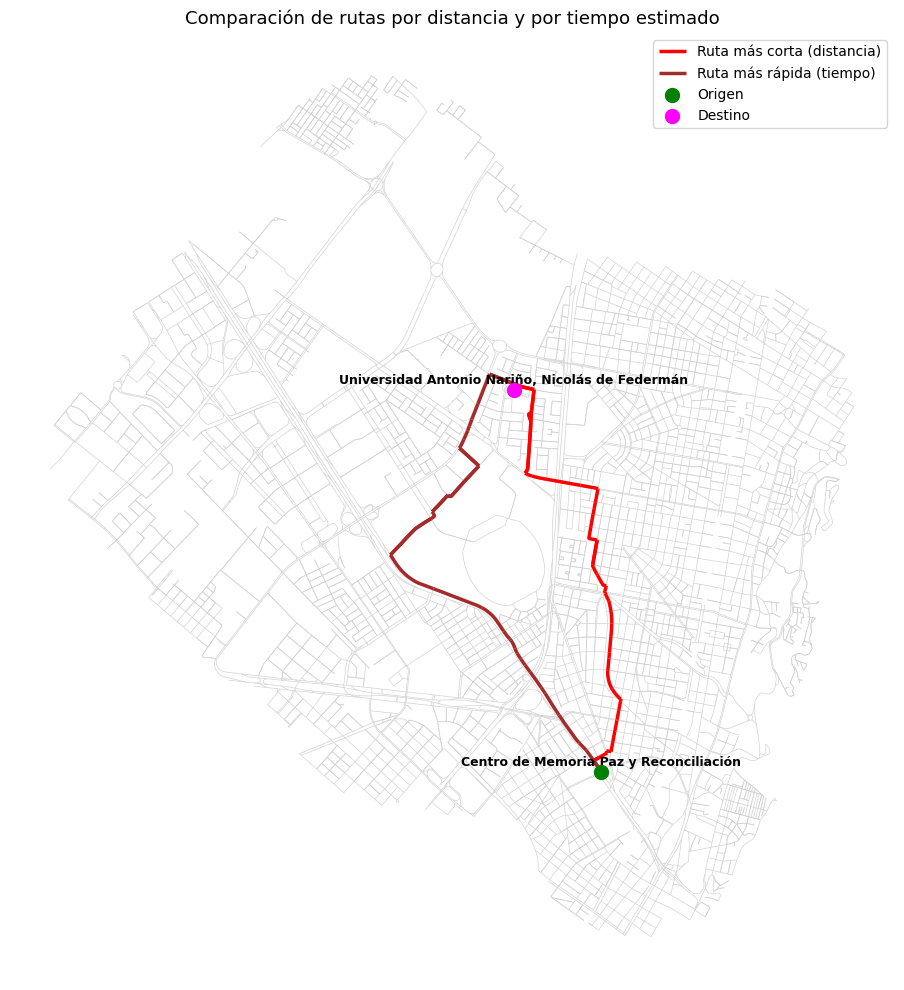

In [150]:
# Obtener geometrías de las rutas desde el grafo
edges_route_dist = ox.graph_to_gdfs(graph_proj.subgraph(ruta_distancia), nodes=False)
edges_route_time = ox.graph_to_gdfs(graph_proj.subgraph(ruta_tiempo), nodes=False)

# Iniciar figura
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar red base
edges_proj.plot(ax=ax, linewidth=0.5, edgecolor="lightgray")

# Dibujar rutas
edges_route_dist.plot(ax=ax, linewidth=2.5, edgecolor="red", label="Ruta más corta (distancia)")
edges_route_time.plot(ax=ax, linewidth=2.5, edgecolor="brown", label="Ruta más rápida (tiempo)")

# Obtener coordenadas de los nodos 
x_o, y_o = graph_proj.nodes[orig_node]["x"], graph_proj.nodes[orig_node]["y"]
x_d, y_d = graph_proj.nodes[dest_node]["x"], graph_proj.nodes[dest_node]["y"]

# Marcar puntos de origen y destino sobre nodos reales
ax.scatter(x_o, y_o, c="green", s=100, label="Origen", zorder=5)
ax.scatter(x_d, y_d, c="magenta", s=100, label="Destino", zorder=5)

# Agregar etiquetas de texto sobre los puntos
ax.text(x_o, y_o + 50, "Centro de Memoria Paz y Reconciliación", fontsize=9, ha="center", color="black", fontweight="bold")
ax.text(x_d, y_d + 50, "Universidad Antonio Nariño, Nicolás de Federmán", fontsize=9, ha="center", color="black", fontweight="bold")

# Mapa final
ax.set_title("Comparación de rutas por distancia y por tiempo estimado", fontsize=13)
ax.axis("off")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

---
#### 4.2.2 Rutas alternativas sin vías principales

En esta sección calculamos una ruta alternativa que evita autopistas y calles principales como `"motorway"`, `"trunk"` y `"primary"`. Esto puede ser útil para usuarios como quienes transportan carga frágil o trabajan en servicios logísticos distribuidos por barrios, quienes pueden requerir trayectos con menor exposición a vías rápidas aunque sean más largos.

Usamos un subgrafo filtrado y verificamos si existe una ruta viable entre el origen y el destino dentro de la componente conexa más grande del grafo resultante.

In [170]:
# Filtrar aristas para excluir vías principales
tipos_excluir = ["motorway", "trunk", "primary"]
edges_full = ox.graph_to_gdfs(graph_proj, nodes=False)

# Limpiar columna highway
edges_full["highway_clean"] = edges_full["highway"].apply(
    lambda x: x[0] if isinstance(x, list) else x
)

# Identificar aristas válidas y construir subgrafo filtrado
vias_permitidas = edges_full[~edges_full["highway_clean"].isin(tipos_excluir)]
edges_to_keep = vias_permitidas[["geometry"]].index
subgrafo_filtrado = graph_proj.edge_subgraph(edges_to_keep).copy()

# Obtener componente conexa más grande (conversión a no dirigido)
G_nodir = subgrafo_filtrado.to_undirected()
componentes = list(nx.connected_components(G_nodir))
mayor_componente = max(componentes, key=len)
subgrafo_conexo = subgrafo_filtrado.subgraph(mayor_componente).copy()

# Buscar nodos más cercanos al origen y destino dentro del subgrafo conexo
def nodo_mas_cercano_en_componente(x, y, G):
    return ox.distance.nearest_nodes(G, x, y)

# Obtener coordenadas de los nodos originales desde graph_proj
x_orig, y_orig = graph_proj.nodes[orig_node]["x"], graph_proj.nodes[orig_node]["y"]
x_dest, y_dest = graph_proj.nodes[dest_node]["x"], graph_proj.nodes[dest_node]["y"]

# Buscar nodos válidos en la componente conexa
nuevo_orig_node = nodo_mas_cercano_en_componente(x_orig, y_orig, subgrafo_conexo)
nuevo_dest_node = nodo_mas_cercano_en_componente(x_dest, y_dest, subgrafo_conexo)

# Intentar calcular ruta alternativa
try:
    ruta_alternativa = nx.shortest_path(subgrafo_conexo, nuevo_orig_node, nuevo_dest_node, weight="length")
    long_alternativa = sum(ox.utils_graph.get_route_edge_attributes(subgrafo_conexo, ruta_alternativa, "length"))

    # Longitud de la ruta original
    long_original = sum(ox.utils_graph.get_route_edge_attributes(graph_proj, ruta_distancia, "length"))

    print(f"Longitud ruta original: {long_original:.2f} metros")
    print(f"Longitud ruta alternativa (sin vías principales): {long_alternativa:.2f} metros")

except nx.NetworkXNoPath:
    print("⚠️ No existe una ruta alternativa que conecte origen y destino sin usar vías principales.")

⚠️ No existe una ruta alternativa que conecte origen y destino sin usar vías principales.


#### Conclusión sobre la ruta alternativa 🚗

Al intentar calcular una ruta alternativa entre el Centro de Memoria, Paz y Reconciliación y la Universidad Antonio Nariño (Nicolás de Federmán), evitando autopistas y calles principales (`motorway`, `trunk` y `primary`), no fue posible encontrar un camino dentro de la red vial disponible. Esto se debe a que el grafo resultante, tras excluir estos tipos de vías, no cuenta con una conexión continua entre los nodos de origen y destino.

Este resultado es coherente si se tiene en cuenta que la red analizada está orientada a vehículos motorizados (carros), cuya movilidad generalmente depende de vías principales para conectar sectores distantes de la ciudad. A diferencia de redes peatonales o ciclorrutas, que podrían ofrecer trayectos alternativos más flexibles y locales, la infraestructura vehicular suele estar más jerarquizada y centralizada.

Por lo tanto, las restricciones de vía pueden limitar severamente la conectividad en el caso del tráfico automotor, especialmente cuando se pretende evitar vías de alta capacidad. Este tipo de análisis es útil para evaluar la dependencia de ciertos segmentos de la red y resalta la importancia de contar con una infraestructura diversa y distribuida para otros modos de transporte como la bicicleta o el peatón.

### 4.3  Construcción y guardado de la ruta óptima como geometría de línea

Una vez obtenida la secuencia de nodos que conforman el camino más corto, podemos crear una geometría tipo `LineString` que una esos puntos y exportarla como archivo vectorial. Esto permite visualizar la ruta completa, calcular su longitud y utilizarla en análisis espaciales posteriores.

#### 4.3.1. Extraer los nodos que componen la ruta (más corta y más rápida)

Seleccionamos los nodos correspondientes a cada ruta (por distancia y por tiempo)  
desde el `GeoDataFrame` de nodos proyectados (`nodes_proj`).

In [181]:
# Nodos que componen la ruta más corta (en distancia)
route_nodes_distancia = nodes_proj.loc[ruta_distancia]

# Nodos que componen la ruta más rápida (por tiempo estimado)
route_nodes_tiempo = nodes_proj.loc[ruta_tiempo]

# Renombrar columnas para diferenciarlas
dist_cols = {col: f"{col}_dist" for col in route_nodes_distancia.columns}
tiem_cols = {col: f"{col}_tiem" for col in route_nodes_tiempo.columns}

route_nodes_distancia_ren = route_nodes_distancia.rename(columns=dist_cols)
route_nodes_tiempo_ren = route_nodes_tiempo.rename(columns=tiem_cols)

# Concatenar lado a lado
comparacion_rutas = pd.concat([route_nodes_distancia_ren.reset_index(drop=True),
                               route_nodes_tiempo_ren.reset_index(drop=True)], axis=1)

# Mostrar la tabla comparativa
comparacion_rutas.head(20)

,y_dist,x_dist,street_count_dist,highway_dist,railway_dist,geometry_dist,y_tiem,x_tiem,street_count_tiem,highway_tiem,railway_tiem,geometry_tiem
0,1.002605e+06,1.000205e+06,4,traffic_signals,NaN,POINT (1000205.034 1002605.142),1.002605e+06,1.000205e+06,4.0,traffic_signals,NaN,POINT (1000205.034 1002605.142)
1,1.002611e+06,1.000201e+06,4,traffic_signals,NaN,POINT (1000200.862 1002611.39),1.002611e+06,1.000201e+06,4.0,traffic_signals,NaN,POINT (1000200.862 1002611.39)
2,1.002704e+06,1.000139e+06,3,NaN,NaN,POINT (1000138.957 1002703.549),1.002704e+06,1.000139e+06,3.0,NaN,NaN,POINT (1000138.957 1002703.549)
3,1.002727e+06,1.000181e+06,4,NaN,NaN,POINT (1000181.144 1002726.848),1.002794e+06,1.000073e+06,3.0,NaN,NaN,POINT (1000073.258 1002794.469)
4,1.002767e+06,1.000247e+06,4,NaN,NaN,POINT (1000247.287 1002766.514),1.002857e+06,1.000013e+06,4.0,NaN,NaN,POINT (1000012.729 1002856.947)
5,1.002770e+06,1.000256e+06,3,NaN,NaN,POINT (1000256.297 1002770.429),1.003101e+06,9.998358e+05,3.0,NaN,NaN,POINT (999835.826 1003100.868)
6,1.002789e+06,1.000251e+06,3,NaN,NaN,POINT (1000250.938 1002788.807),1.003292e+06,9.997140e+05,3.0,NaN,NaN,POINT (999714.004 1003292.042)
7,1.002781e+06,1.000291e+06,4,NaN,NaN,POINT (1000291.327 1002781.321),1.003341e+06,9.996805e+05,3.0,NaN,NaN,POINT (999680.495 1003340.963)
8,1.002865e+06,1.000306e+06,4,NaN,NaN,POINT (1000306.062 1002865.241),1.003478e+06,9.995830e+05,3.0,NaN,NaN,POINT (999582.985 1003477.764)
9,1.002961e+06,1.000324e+06,4,NaN,NaN,POINT (1000324.359 1002960.939),1.003538e+06,9.995393e+05,3.0,NaN,NaN,POINT (999539.267 1003537.71)


#### 4.3.2 Crear una geometría `LineString` a partir de los puntos

Se construye una `LineString` para cada ruta usando la secuencia de nodos correspondiente.

In [183]:
from shapely.geometry import LineString

# Geometría de línea para ruta más corta (distancia)
route_line_distancia = LineString(list(route_nodes_distancia.geometry.values))

# Geometría de línea para ruta más rápida (tiempo)
route_line_tiempo = LineString(list(route_nodes_tiempo.geometry.values))

#### 4.3.3 Convertir cada línea en un `GeoDataFrame` con metadatos

Se incluyen la geometría, los nodos usados en cada ruta y la longitud total en metros.

In [184]:
# GeoDataFrame para la ruta más corta
route_geom_distancia = gpd.GeoDataFrame(
    {
        "geometry": [route_line_distancia],
        "osm_nodes": [ruta_distancia],
        "tipo": ["distancia"]
    },
    crs=edges_proj.crs
)
route_geom_distancia["length_m"] = route_geom_distancia.length

# GeoDataFrame para la ruta más rápida
route_geom_tiempo = gpd.GeoDataFrame(
    {
        "geometry": [route_line_tiempo],
        "osm_nodes": [ruta_tiempo],
        "tipo": ["tiempo"]
    },
    crs=edges_proj.crs
)
route_geom_tiempo["length_m"] = route_geom_tiempo.length

#### 4.4.4 Crear un `GeoDataFrame` con las rutas por distancia y por tiempo

Se genera un `GeoDataFrame` para cada ruta, incluyendo:
- La geometría (`LineString`)
- La lista de nodos OSM (`osm_nodes`)
- La longitud en metros (`length_m`)
- El tipo de ruta (`distancia` o `tiempo`)

Ambos `GeoDataFrame` se combinan en una sola tabla y se guardan juntos en un archivo `GeoPackage` (`.gpkg`) para facilitar su visualización y análisis posterior.

In [185]:
# GeoDataFrame para la ruta más corta (distancia)
route_geom_distancia = gpd.GeoDataFrame(
    {
        "geometry": [route_line_distancia],
        "osm_nodes": [ruta_distancia],
        "tipo": ["distancia"]
    },
    crs=edges_proj.crs
)
route_geom_distancia["length_m"] = route_geom_distancia.length

# GeoDataFrame para la ruta más rápida (tiempo)
route_geom_tiempo = gpd.GeoDataFrame(
    {
        "geometry": [route_line_tiempo],
        "osm_nodes": [ruta_tiempo],
        "tipo": ["tiempo"]
    },
    crs=edges_proj.crs
)
route_geom_tiempo["length_m"] = route_geom_tiempo.length

# Unir ambas rutas en un solo GeoDataFrame
rutas_geom = pd.concat([route_geom_distancia, route_geom_tiempo], ignore_index=True)

# Guardar en un archivo GeoPackage
rutas_geom.to_file("rutas_optimas.gpkg", layer="rutas", driver="GPKG")

# Verificar contenido
rutas_geom

,geometry,osm_nodes,tipo,length_m
0,"LINESTRING (1000205.034 1002605.142, 1000200.8...","[263777169, 263777194, 264153962, 264153963, 2...",distancia,4331.773002
1,"LINESTRING (1000205.034 1002605.142, 1000200.8...","[263777169, 263777194, 264153962, 264153953, 3...",tiempo,5051.669960


#### 4.4.5 Descargar edificios del área de estudio

Para enriquecer la visualización del contexto urbano, descargamos las geometrías de los edificios ubicados dentro del área definida por `PLACE_NAME`, directamente desde OpenStreetMap.  
Luego, reproyectamos al mismo sistema de referencia espacial (`CRS`) usado en las aristas del grafo (`edges_proj`).

In [186]:
# Descargar edificios del lugar definido
buildings = ox.features_from_place(
    PLACE_NAME,
    tags={"building": True}
).to_crs(edges_proj.crs)

# Verificar contenido
buildings.head()

geometry          amenity  \
element id                                                           
node    262714667  POINT (999512.155 1004592.857)  bicycle_parking   
        262714673  POINT (999011.557 1004381.209)  bicycle_parking   
        262714674  POINT (999128.461 1004271.842)  bicycle_parking   
        602896517  POINT (999322.403 1004088.684)  bicycle_parking   
        602896520  POINT (999419.681 1004264.973)  bicycle_parking   

                  bicycle_parking    building covered capacity  fee  \
element id                                                            
node    262714667        informal  university      no      NaN  NaN   
        262714673             NaN  university     NaN      NaN  NaN   
        262714674             NaN  university     NaN      NaN  NaN   
        602896517    ground_slots  university      no       40  $ 0   
        602896520             NaN  university     NaN      NaN  NaN   

                               name operator  ref  ... website:menu  \
element id                                         ...                
node    262714667               NaN      NaN  NaN  ...          NaN   
        262714673               NaN      NaN  NaN  ...          NaN   
        262714674               NaN      NaN  NaN  ...          NaN   
        602896517  Cicloparqueadero     Unal  NaN  ...          NaN   
        602896520               NaN      NaN  NaN  ...          NaN   

                  community_centre type image name:etymology:wikidata club  \
element id                                                                   
node    262714667              NaN  NaN   NaN                     NaN  NaN   
        262714673              NaN  NaN   NaN                     NaN  NaN   
        262714674              NaN  NaN   NaN                     NaN  NaN   
        602896517              NaN  NaN   NaN                     NaN  NaN   
        602896520              NaN  NaN   NaN                     NaN  NaN   

                  air_conditioning subject:wikidata subject:wikipedia subway  
element id                                                                    
node    262714667              NaN              NaN               NaN    NaN  
        262714673              NaN              NaN               NaN    NaN  
        262714674              NaN              NaN               NaN    NaN  
        602896517              NaN              NaN               NaN    NaN  
        602896520              NaN              NaN               NaN    NaN  

[5 rows x 174 columns]

### 5. Visualización final de resultados

En este paso visualizamos:

- La red vial (`edges_proj`)
- Las dos rutas óptimas (`rutas_geom`), diferenciadas por tipo (`distancia` y `tiempo`)
- Los edificios descargados desde OpenStreetMap (`buildings`)
- El nodo de origen (`orig_node`) y el nodo de destino (`dest_node`)

Esto nos permite validar espacialmente que la red y las rutas están correctamente alineadas,  
y entender su contexto urbano inmediato.

/tmp/ipykernel_419/3169086074.py:42: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


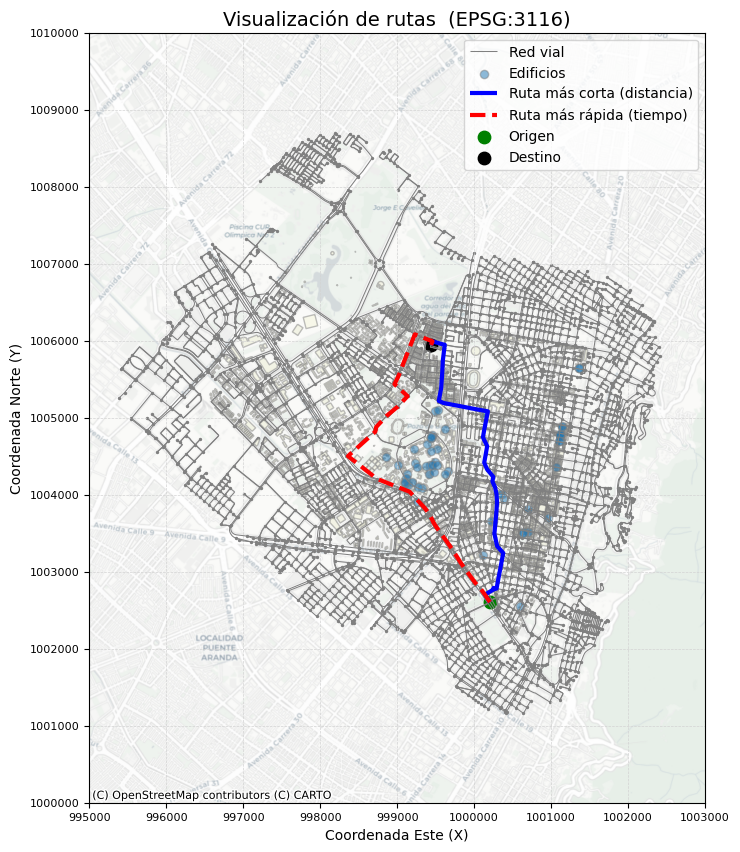

In [196]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar red vial
edges_proj.plot(ax=ax, linewidth=0.75, color='gray', label="Red vial")
nodes_proj.plot(ax=ax, markersize=2, color='gray')

# Dibujar edificios 
if 'buildings' in locals():
    buildings.plot(ax=ax, facecolor='beige', edgecolor='gray', alpha=0.5, label="Edificios")

# Dibujar rutas
rutas_geom[rutas_geom["tipo"] == "distancia"].plot(ax=ax, linewidth=3, color='blue', label="Ruta más corta (distancia)")
rutas_geom[rutas_geom["tipo"] == "tiempo"].plot(ax=ax, linewidth=3, color='red', linestyle='--', label="Ruta más rápida (tiempo)")

# Dibujar nodos origen y destino
nodes_proj.loc[[orig_node]].plot(ax=ax, color='green', markersize=80, label='Origen')
nodes_proj.loc[[dest_node]].plot(ax=ax, color='black', markersize=80, label='Destino')

# Agregar mapa base
ctx.add_basemap(ax, crs=edges_proj.crs, source=ctx.providers.CartoDB.Positron)

# Activar retícula
ax.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)

# Fijar espaciado de grilla
x_ticks = range(int(ax.get_xlim()[0] // 1000 * 1000), int(ax.get_xlim()[1]) + 1000, 1000)
y_ticks = range(int(ax.get_ylim()[0] // 1000 * 1000), int(ax.get_ylim()[1]) + 1000, 1000)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.ticklabel_format(style='plain')


# Mostrar valores en ejes
ax.tick_params(labelsize=8)
ax.set_xlabel("Coordenada Este (X)", fontsize=10)
ax.set_ylabel("Coordenada Norte (Y)", fontsize=10)

# Título y leyenda
ax.set_title("Visualización de rutas  (EPSG:3116)", fontsize=14)
ax.legend()
plt.show()

### 6. Preparar datos para guardar en archivo

Al guardar `GeoDataFrames` en formato de archivo (como `.shp` o `.gpkg`), es importante asegurarse de que las columnas no contengan tipos de datos no compatibles, como listas o diccionarios.

En este caso:

- Algunas columnas del `GeoDataFrame` de aristas (`edges`) contienen listas u objetos que podrían causar errores al exportar.
- Por ejemplo, columnas como `"osmid"` o `"name"` pueden estar en formato `list`.
- Se identifican las columnas problemáticas y se convierten explícitamente a cadenas (`str`) para evitar errores en la escritura.

También se convierte la columna `"osm_nodes"` del `GeoDataFrame` de rutas, si contiene listas de nodos, al mismo formato de cadena.

In [198]:
# Lista completa de posibles columnas problemáticas
problematic_columns = [
    "osmid", "lanes", "name", "highway", "width", "maxspeed", 
    "reversed", "junction", "bridge", "tunnel", "access", "service"
]

# Filtrar solo las que realmente existen en 'edges'
valid_columns = [col for col in problematic_columns if col in edges.columns]

# Convertir a string las columnas válidas
edges[valid_columns] = edges[valid_columns].astype(str)

# Convertir la lista de nodos en rutas a string (por si aún es lista)
rutas_geom["osm_nodes"] = rutas_geom["osm_nodes"].astype(str)


### 7. Crear carpeta de salida para guardar los archivos

Antes de guardar los resultados en archivos `.gpkg`, `.shp` u otros formatos vectoriales, definimos una carpeta de salida llamada `data` en el mismo directorio donde se encuentra este notebook. Usamos la librería `pathlib` para:

- Detectar la ruta actual del notebook.
- Crear (si no existe) la carpeta `data`, donde se guardarán todos los resultados.

In [199]:
import pathlib

# Ruta del notebook actual
NOTEBOOK_PATH = pathlib.Path().resolve()

# Directorio de salida
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

# Crear carpeta si no existe
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)